# LSTM Stock Predictor Using Fear and Greed Index

## Data Preparation

In [108]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [109]:
# Set the random seed for reproducibility
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [110]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [111]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [112]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [113]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [114]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [201]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 1

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [202]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
y_train = y[: split]

X_test = X[split:]
y_test = y[split:]

In [203]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [204]:
# Reshape the features for the model

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [205]:
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.25287356]]

 [[0.08045977]]

 [[0.36781609]]

 [[0.18390805]]

 [[0.03448276]]] 

X_test sample values:
[[[0.40229885]]

 [[0.37931034]]

 [[0.34482759]]

 [[0.63218391]]

 [[0.65517241]]]


## Build and Train the LSTM RNN

In [206]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [207]:
# Build the LSTM model

# Define the LSTM RNN model.
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [208]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [209]:
# Summarize the model
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 1, 30)             3840      
_________________________________________________________________
dropout_27 (Dropout)         (None, 1, 30)             0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 1, 30)             7320      
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 30)             0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_29 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)               

In [210]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
378/378 [==============================] - 3s 2ms/step - loss: 0.1411
Epoch 2/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0848
Epoch 3/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0821
Epoch 4/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0771
Epoch 5/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0748
Epoch 6/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0717
Epoch 7/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0715
Epoch 8/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0689
Epoch 9/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0699
Epoch 10/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0732


## Model Performance

In [211]:
# Evaluate the model
model.evaluate(X_test, y_test)

6/6 [==============================] - 1s 0s/step - loss: 0.1117


0.11165650188922882

In [212]:
# Make some predictions
predicted = model.predict(X_test)

In [213]:
predicted_prices = scaler.inverse_transform(predicted.reshape(-1,1))
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

In [214]:
# Create a DataFrame of Real and Predicted values
btc = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
btc.head()

,Real,Predicted
2019-02-17,3670.919922,4576.325195
2019-02-18,3670.919922,4500.483887
2019-02-19,3912.570068,4385.403809
2019-02-20,3924.239990,5276.657227
2019-02-21,3974.050049,5339.257324


<AxesSubplot:>

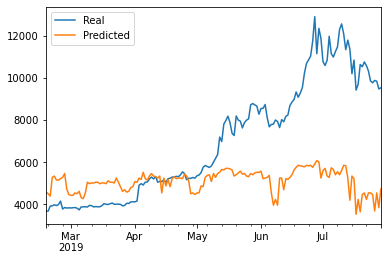

In [215]:
# Plot the real vs predicted prices as a line chart
btc.plot()